# Cleaning bridges

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

from shapely.geometry import Point

In [23]:
# Import the bridge data
df_brd = pd.read_excel('data/BMMS_overview.xlsx')
df_brd.head(5)

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,width,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc
0,N1,1.800,Box Culvert,LRP001a,.,11.30,A,117861,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,1.8,19.5,2005.0,2.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.702889,90.450389,bcs1
1,N1,4.925,Box Culvert,LRP004b,.,6.60,A,117862,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,4.925,35.4,2006.0,1.0,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.693611,90.478833,bcs1
2,N1,8.976,PC Girder Bridge,LRP008b,Kanch pur Bridge.,394.23,A,119889,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,8.976,NaN,NaN,NaN,Dhaka,Dhaka,Narayanganj,Narayanganj-1,23.704583,90.518833,road_precise
3,N1,10.880,Box Culvert,LRP010b,NOYAPARA CULVERT,6.30,A,112531,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,10.88,12.2,1992.0,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.699833,90.530722,bcs1
4,N1,10.897,Box Culvert,LRP010c,ADUPUR CULVERT,6.30,A,112532,Dhaka (Jatrabari)-Comilla (Mainamati)-Chittago...,10.897,12.2,1984.0,2.0,Dhaka,Dhaka,Narayanganj,Vitikandi,23.699667,90.530722,bcs1


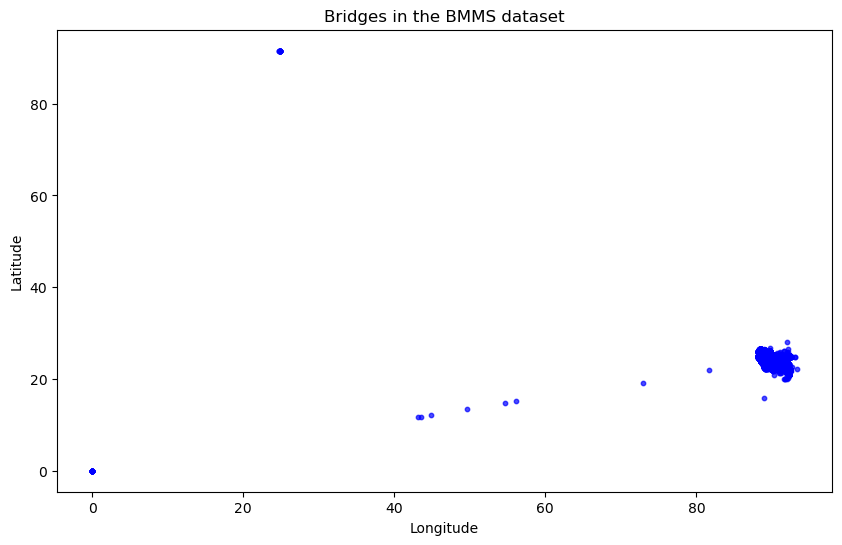

In [4]:
# Create plot function for the bridges
def plot_bridges(df):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create a scatter plot
    ax.scatter(df['lon'], df['lat'], s=10, color='blue', alpha=0.7)

    # Set the title and labels
    ax.set_title('Bridges in the BMMS dataset')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Display the plot
    plt.show()

# Plot the bridges
plot_bridges(df_brd)


### Step 1: Filter datapoints that are not located in bangladesh

In [5]:
import geopandas as gpd
gdf = gpd.read_file('data/shapefile_bangladesh')
gdf

,OBJECTID,featurecla,LEVEL,TYPE,FORMAL_EN,FORMAL_FR,POP_EST,POP_RANK,GDP_MD_EST,POP_YEAR,...,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,WB_NAME,WB_RULES,WB_REGION,Shape_Leng,Shape_Area,geometry
0,124,Admin-0 country,2,Sovereign country,People's Republic of Bangladesh,None,157826578,17,628400.0,2017,...,Bangladesh,Bangladeş,Bangladesh,孟加拉国,Bangladesh,None,SOA,53.187135,12.136245,"MULTIPOLYGON (((92.57588 21.97757, 92.59024 21..."


I use a buffer, as the shapefile is not that precise

C:\Users\groen\AppData\Local\Temp\ipykernel_7144\3601603436.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bridges_outside = gdf_bridges[~gdf_bridges.geometry.within(bangladesh_buffered.unary_union)]
C:\Users\groen\AppData\Local\Temp\ipykernel_7144\3601603436.py:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  bridges_inside = gdf_bridges[gdf_bridges.geometry.within(bangladesh_buffered.unary_union)]


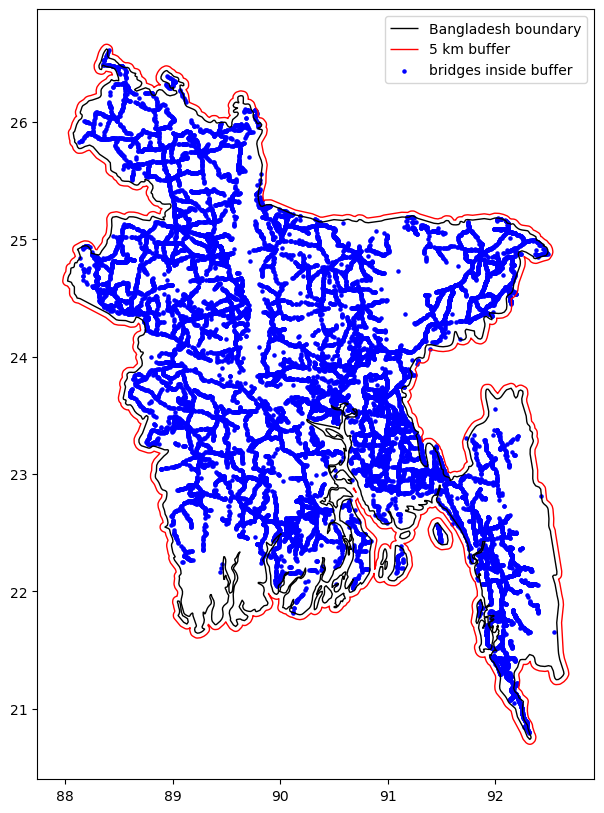

In [6]:
from shapely.geometry import Point

# Load the shapefile of Bangladesh
bangladesh_shape = gdf  # Update with actual file path

# Create a buffer of 5 km (5000 meters) around the Bangladesh boundary
bangladesh_buffered = bangladesh_shape.to_crs(epsg=3857).buffer(5000).to_crs(epsg=4326)

# Convert bridge locations into a GeoDataFrame
df_bridges = df_brd
geometry = [Point(lon, lat) for lon, lat in zip(df_bridges["lon"], df_bridges["lat"])]
gdf_bridges = gpd.GeoDataFrame(df_bridges, geometry=geometry, crs="EPSG:4326")

# Filter bridges that are **outside** the buffered area
bridges_outside = gdf_bridges[~gdf_bridges.geometry.within(bangladesh_buffered.unary_union)]
bridges_inside = gdf_bridges[gdf_bridges.geometry.within(bangladesh_buffered.unary_union)]

# Display the bridges in 5 km buffer zone of Bangladesh
fig, ax = plt.subplots(figsize=(10, 10))
bangladesh_shape.boundary.plot(ax=ax, edgecolor='black', linewidth=1, label='Bangladesh boundary')
bangladesh_buffered.boundary.plot(ax=ax, edgecolor='red', linewidth=1, label='5 km buffer')
bridges_inside.plot(ax=ax, color='blue', markersize=5, label='bridges inside buffer')
ax.legend()
plt.show()


We now have a dataframe with all bridges that are not located in bangladesh

In [16]:
# # Check if lat lon coordinates are changed

# def check_lat_lon(df, shapefile):
#     # Check if the latitude and longitude columns are within the expected range
#     for _, row in df.iterrows():
#         if row['lat'] < 21 or row['lat'] > 26 and row['lon'] < 88 or row['lon'] > 93:

#             # Change the lon and lat values of this row, changed, are in the shapefile
#             point = Point(row['lat'], row['lon'])
#             if point.within(shapefile.unary_union):
#                 print("Changed coordinates show location in bangladesh")
#     return


# check_lat_lon(bridges_outside.copy(), bangladesh_buffered)


In [ ]:
def check_and_update_lat_lon(df, shapefile):
    bridges_to_remove = []

    # Iterate through each row in the DataFrame of bridges not in Bangladesh
    for _, row in df.iterrows():
        # Check if the coordinates are outside the expected range
        if not (21 <= row['lat'] <= 26 and 88 <= row['lon'] <= 93):
            point = Point(row['lat'], row['lon'])

            if point.within(shapefile.unary_union):
                bridges_to_remove.append(row['name']) 

    # Now we update the original df by removing the rows
    df_cleaned = df[~df['name'].isin(bridges_to_remove)].copy()

    return df_cleaned, bridges_to_remove

# Call the function and remove bridges that are within Bangladesh but outside the expected range
updated_bridges_outside, removed_bridges = check_and_update_lat_lon(bridges_outside.copy(), bangladesh_buffered)

# Print the removed bridges and the updated GeoDataFrame
print(f"Removed bridges: {removed_bridges}")

for bridge in removed_bridges:
    # Swap lat and lon removed_bridges in the original GeoDataFrame
    gdf_bridges.loc[gdf_bridges['name'] == bridge, 'lat'], gdf_bridges.loc[gdf_bridges['name'] == bridge, 'lon'] = \
        gdf_bridges.loc[gdf_bridges['name'] == bridge, 'lon'].values, \
        gdf_bridges.loc[gdf_bridges['name'] == bridge, 'lat'].values


C:\Users\groen\AppData\Local\Temp\ipykernel_7144\3123436132.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  if point.within(shapefile.unary_union):


Removed bridges: ['MAJIDEPUR BOX CULVERT', 'KHASIRA BAILEY WITH STEEL DECK', 'KOLKALI BOX CULVERT', 'KOKAL BOX CULVERT', 'TARAKHAI BOX CULVERT', 'COUNDER NOLA BRIDGE', 'EKOR CHOL BOX CULVERT', 'MAJIDPUR TRUSS BRIDGE', 'HIJLA BOX CULVERT', 'KHASIRA BOX CULVERT', 'GONGUR BAILEY WITH STEEL DECK', 'TARA KHAI BRIDGE', 'COUNDER NOLA BOX CULVERT', 'BOMBOMI BRIDGE', 'EKOR CHAI BOX CULVERT']


In [21]:
# Control if the lat lon of these bridges are good using one example
gdf_bridges[gdf_bridges['name'] ==  'MAJIDEPUR BOX CULVERT']

,road,km,type,LRPName,name,length,condition,structureNr,roadName,chainage,...,constructionYear,spans,zone,circle,division,sub-division,lat,lon,EstimatedLoc,geometry
2864,R241,29.84,Box Culvert,LRP029a,MAJIDEPUR BOX CULVERT,3.0,A,114991,Auskandi-Raniganj-Jagannathpur-Pagla Road,29.84,...,1992.0,1.0,Sylhet,Sylhet,Sunamganj,Chattak,24.805111,91.543889,bcs1,POINT (24.80511 91.54389)


## Check for change in min / sec 